In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from scipy.stats import zscore,sem
from statsmodels.stats.multitest import multipletests
import matplotlib as mpl

In [2]:
%cd "/home/unix/sjohri/valab_sjohri/projects/github_code/beanie"

/broad/VanAllenLab/xchip/cga_home/sjohri/projects/github_code/beanie


In [3]:
import beanie.beanie as bn

/home/unix/sjohri/.local/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
counts_mat = "./data/nsclc/kim/adata_exp3.h5ad"
metad_mat = "./data/nsclc/kim/metad_exp3.csv"
sig_file = "./data/signatures/signatures_lung2.csv"

In [5]:
beanie_obj_lung = bn.Beanie(counts_path = counts_mat, 
                                metad_path = metad_mat, 
                                sig_path = sig_file, 
                                normalised = True, 
                                test_direction="late-tumor")
beanie_obj_lung.SignatureScoring("mean")

************************************************************
Reading counts matrix...
Reading meta data file...
Reading signature file...
************************************************************


## Extracting information

In [6]:
# Vision signatures
vision_sig = beanie_obj_lung.signature_scores

# Signatures file
sig_df = beanie_obj_lung.signatures

# Counts 
counts_df = beanie_obj_lung.normalised_counts

In [7]:
print(vision_sig.shape,sig_df.shape,counts_df.shape)

(11586, 47) (476, 47) (27578, 11586)


In [8]:
signature_names_list = vision_sig.columns

In [9]:
t1_ids = beanie_obj_lung.t1_ids
t2_ids = beanie_obj_lung.t2_ids

In [10]:
d1_all = beanie_obj_lung.d1_all
d2_all = beanie_obj_lung.d2_all

## Package Code

In [32]:
def CalculateLog2FoldChangeHelper(a1,a2):
    
    # note: values in log-normalised matrix are all positive
    gr1 = np.log2(np.mean([y for x,y in a1.items()])+0.000001)
    gr2 = np.log2(np.mean([y for x,y in a2.items()])+0.000001)
    log2fold = abs(gr1-gr2)
    direction = gr1>gr2                
    return [log2fold,direction]       

def OutlierDetector(a):
    a_vals = list(a.values())
    q25 = np.quantile(a_vals,0.25)
    q75 = np.quantile(a_vals,0.75)
    outlier_bottom_lim = q25 - 1.5 * (q75 - q25)
    outlier_upper_lim = q75 + 1.5 * (q75 - q25)
    if (a_vals>outlier_upper_lim).sum()>0 or (a_vals<outlier_bottom_lim).sum()>0:
        return True
    else:
        return False

def CalculateLog2FoldChange(signature_genes,counts_matrix,d1,d2):
    """
    Function for calculating log2fold change and direction. Helper function for driver_genes module.
    
    Parameters:
        counts_matrix              cells x genes counts matrix
        signature_genes            list of genes which are contained in the signature_name
        d1                         directionary mapping patient id to cells in group of interest
        d2                         directionary mapping patient id to cells in reference group
        
    """
    t1_ids = list(d1.keys())
    t2_ids = list(d2.keys())
    
    test_coeff = []
    for gene in signature_genes:
        if gene in counts_matrix.columns:
            a1=dict()
            a2=dict()
            for id_name in t1_ids:
                a1[id_name] = counts_matrix.loc[d1[id_name],gene].mean()
            for id_name in t2_ids:
                a2[id_name] = counts_matrix.loc[d2[id_name],gene].mean()
            
            # find outliers
            gr1_outlier = OutlierDetector(a1)
            gr2_outlier = OutlierDetector(a2)
            
            # check robustness
            fold_list = []
            for fold in t1_ids:
                a1_temp = {key: value for key, value in a1.items() if key != fold}
                fold_list.append(CalculateLog2FoldChangeHelper(a1_temp,a2)) 
            for fold in t2_ids:
                a2_temp = {key: value for key, value in a2.items() if key != fold}
                fold_list.append(CalculateLog2FoldChangeHelper(a1,a2_temp))
            
            log2fold = np.mean([x[0] for x in fold_list]) 
            std_err = sem([x[0] for x in fold_list])
            dirs = [x[1] for x in fold_list]
            direction = max(dirs, key = dirs.count)
            robustness_ratio = dirs.count(direction)/len(dirs)
            test_coeff.append([gene,gr1_outlier,gr2_outlier,log2fold,std_err,direction,robustness_ratio])    
            
    return test_coeff

def FindTopGenes(coeff_matrix, no_of_genes:int):
#     correction_method = "bonferroni"
    
    if no_of_genes>len(coeff_matrix):
        no_of_genes = len(coeff_matrix)
    df = pd.DataFrame(coeff_matrix, columns=["gene_name","gr1_outlier","gr2_outlier",
                                             "log2fold","std_error","direction","robustness_ratio"])
    df = df.set_index("gene_name")
    df['direction_okay'] = 'NA'
    # select only significant genes
    df = df[(df.log2fold>=0.5) & (df.robustness_ratio>=0.9) & (df.gr1_outlier==False) & (df.gr2_outlier==False)]
    gr = df.groupby("direction").groups
    try:
        df = df.loc[gr[True],].sort_values(["robustness_ratio","log2fold"],ascending=(False,False))
        df['direction_okay'] = True
        return df.iloc[:min(no_of_genes,df.shape[0]),:]
    except KeyError:
        # case when there is no gene in the signature enriched in the direction of interest...
#         return None
        try:
            df = df.loc[gr[False],].sort_values(["robustness_ratio","log2fold"],ascending=(False,False))
            df['direction_okay'] = False
            return df.iloc[:min(no_of_genes,df.shape[0]),:]
        except KeyError:
            return None


def FindDriverGenes(signature_name, signature_matrix, counts_matrix, signature_genes, d1, d2, no_of_genes=10):
    """ Perform correlation test to find genes which are correlated to the signature score.
    
    Parameters:
        signature_name             name of the signature
        signature_matrix           cells x signatures matrix for calculated signature scores
        counts_matrix              cells x genes counts matrix
        signature_genes            list of genes which are contained in the signature_name
        d1                         directionary mapping patient id to cells in group of interest
        d2                         directionary mapping patient id to cells in reference group
        no_of_genes                number of top genes required to calculate
    
    """
    if not signature_matrix.index.equals(counts_matrix.index):
#         print("OOPS")
        pass

    results_list = CalculateLog2FoldChange(signature_genes,counts_matrix,d1,d2)
            
    top_genes = FindTopGenes(results_list, no_of_genes)
    return top_genes


def GenerateHeatmapFigure(df1_list, df2_list, signature_list, **kwargs):
    """Function for plotting the actual heatmap.
    
    Parameters:
        df1_list                                      dictionary mapping signature name to df containing mean expression per patient for the gene, for treatment group 1
        df2_list                                      dictionary mapping signature name to df containing mean expression per patient for the gene, for treatment group 2
        signature_list                                list of signature names to plot
    
    """
    # how to place the labels of the heatmap
    orientation = "horizontal"
    cmap_name = "Blues"
    
    v_high = max(pd.concat(df1_list.values()).max().max(),pd.concat(df2_list.values()).max().max())
    v_low = min(pd.concat(df1_list.values()).min().min(),pd.concat(df2_list.values()).min().min())
    with sns.plotting_context("notebook", rc={'axes.titlesize' : 12,
                                           'axes.labelsize' : 8,
                                           'xtick.labelsize' : 10,
                                           'ytick.labelsize' : 8,
                                           'font.name' : 'Arial'}):

        fig, axs = plt.subplots(len(signature_list),2,figsize=(10, max(1.4*max(len(signature_list),5), 0.5*df1_list[signature_list[0]].shape[0])), dpi=300)
        cbar_ax = fig.add_axes([0.91,.3,.03,.4])
        max_i = len(axs.flat)
        for i, ax in enumerate(axs.flat):
            if i%2==0:
                df = df1_list[signature_list[int(i/2)]]
                im = sns.heatmap(df, ax=ax,
                        cbar=i == 0,
                        vmin=v_low, vmax=v_high,
                        cbar_ax=None if i else cbar_ax, 
                        xticklabels = False if i!=max_i-2 else df1_list[signature_list[0]].columns,
                        yticklabels = df.index,
                        cmap = cmap_name)
                if orientation == "horizontal":
                    lab = signature_list[int(i/2)]
                    lab_len = len(signature_list[int(i/2)])
                    ax.set_ylabel(lab[0:int(lab_len/2)]+"\n"+lab[int(lab_len/2):], labelpad=50, rotation=0)
                else:
                    ax.set_ylabel(signature_list[int(i/2)], labelpad=10+10*(i%4))

            else:
                df = df2_list[signature_list[int(i/2)]]
                im = sns.heatmap(df, ax=ax,
                        cbar=i == 0,
                        vmin=v_low, vmax=v_high,
                        cbar_ax=None if i else cbar_ax, 
                        xticklabels = False if i!=max_i-1 else df2_list[signature_list[0]].columns, 
                        yticklabels = False,
                        cmap = cmap_name)

        fig.suptitle("Heatmap for Robust Signatures", fontsize=15)
        plt.subplots_adjust(hspace = 0.05, wspace = 0.01, left=0, right=0.9, top=0.95, bottom=0)
        return

def GenerateHeatmap(counts_matrix, t1_ids, t2_ids, d1, d2, top_genes:dict, signature_list:list, **kwargs):
    """Function to prepare data for GenerateHeatmapFigure()
    
    Parameters: 
        counts                                       (cells x genes) counts matrix
        t1_ids                                       list of patient ids in treatment group 1
        t2_ids                                       list of patient ids in treatment group 2
        d1                                           dictionary mapping patient ids to cell ids for treatment group 1
        d2                                           dictionary mapping patient ids to cell ids for treatment group 2
        top_genes                                    dictionary mapping signature name to a df of top gene names, p val and correlation coeff
        signature_list                               list of signature names to be plotted in the heatmap
    
    """
    df1_dict = dict()
    df2_dict = dict()
    sig_list_robust = []
    gr1_pats = len(t1_ids)
    gr2_pats = len(t2_ids)
    
    all_genes = list()
    for df in top_genes.values():
        try:
            all_genes.extend(df.index)
        except AttributeError:
            pass

    for sig_name in signature_list:
        try:
            gene_names = top_genes[sig_name].index.to_list()
            sig_list_robust.append(sig_name)
        except AttributeError:
            print("Signature " + sig_name + " does not have a robust gene differential.")
            continue
        
        df1 = pd.DataFrame(columns=t1_ids)
        for t1 in t1_ids:
            df1[t1] = counts_matrix.loc[d1[t1],gene_names].mean(axis=0)
        df1_dict[sig_name] = df1
        
        df2 = pd.DataFrame(columns=t2_ids)
        for t2 in t2_ids:
            df2[t2] = counts_matrix.loc[d2[t2],gene_names].mean(axis=0)
        df2_dict[sig_name]=df2
        
        # scaling each gene for plot:
        for gene in gene_names:
            temp = np.append(df1_dict[sig_name].loc[gene,].values, df2_dict[sig_name].loc[gene,].values)
            temp_scaled = (temp-np.min(temp))/(np.max(temp)-np.min(temp))
#             temp_scaled = temp/np.max(temp)
            df1_dict[sig_name].loc[gene,] = temp_scaled[:gr1_pats]
            df2_dict[sig_name].loc[gene,] = temp_scaled[-gr2_pats:]

    return GenerateHeatmapFigure(df1_dict, df2_dict, sig_list_robust,**kwargs)


## Test package

In [33]:
top_genes = dict()
for x in tqdm(signature_names_list):
    top_genes[x] = FindDriverGenes(x, vision_sig, counts_df.T, sig_df[x].dropna().values, d1_all, d2_all, no_of_genes=10)

In [34]:
for x in top_genes.keys():
    try:
        temp = top_genes[x].index
    except AttributeError:
        print(x)

INAMURA_LUNG_CANCER_SCC_UP
SPIRA_SMOKERS_LUNG_CANCER_DN
TOMIDA_LUNG_CANCER_POOR_SURVIVAL
YANAGISAWA_LUNG_CANCER_RECURRENCE


In [36]:
sig_df['INAMURA_LUNG_CANCER_SCC_UP'].dropna()

0       CDCA5
1        DSC3
2        DSG3
3       KRT14
4        KRT5
5     NECTIN1
6       OSGEP
7       PSMA8
8     SELENOI
9         SFN
10     SLC2A1
11      TOP2A
12       TPX2
Name: INAMURA_LUNG_CANCER_SCC_UP, dtype: object

In [37]:
sig_df['SPIRA_SMOKERS_LUNG_CANCER_DN'].dropna()

0       ALMS1
1      ATP8B1
2      CCDC81
3     DCLRE1C
4       DUOX1
5      GTF2H3
6        LMO4
7       PRR11
8         SPN
9     STAG3L1
10      TCAF1
11       TSR1
12     ZC3H7B
13     ZNF160
14     ZNF611
Name: SPIRA_SMOKERS_LUNG_CANCER_DN, dtype: object

In [38]:
sig_df['TOMIDA_LUNG_CANCER_POOR_SURVIVAL'].dropna()

0    CKAP4
1     DAD1
2     DLX4
3     DNER
4     TYMS
Name: TOMIDA_LUNG_CANCER_POOR_SURVIVAL, dtype: object

In [39]:
sig_df['YANAGISAWA_LUNG_CANCER_RECURRENCE'].dropna()

0      ACYP1
1     ATP1A2
2        FAU
3      H2AC8
4    RPL26L1
5      RPL39
6     S100A6
7     TMSB10
8     TMSB4X
Name: YANAGISAWA_LUNG_CANCER_RECURRENCE, dtype: object

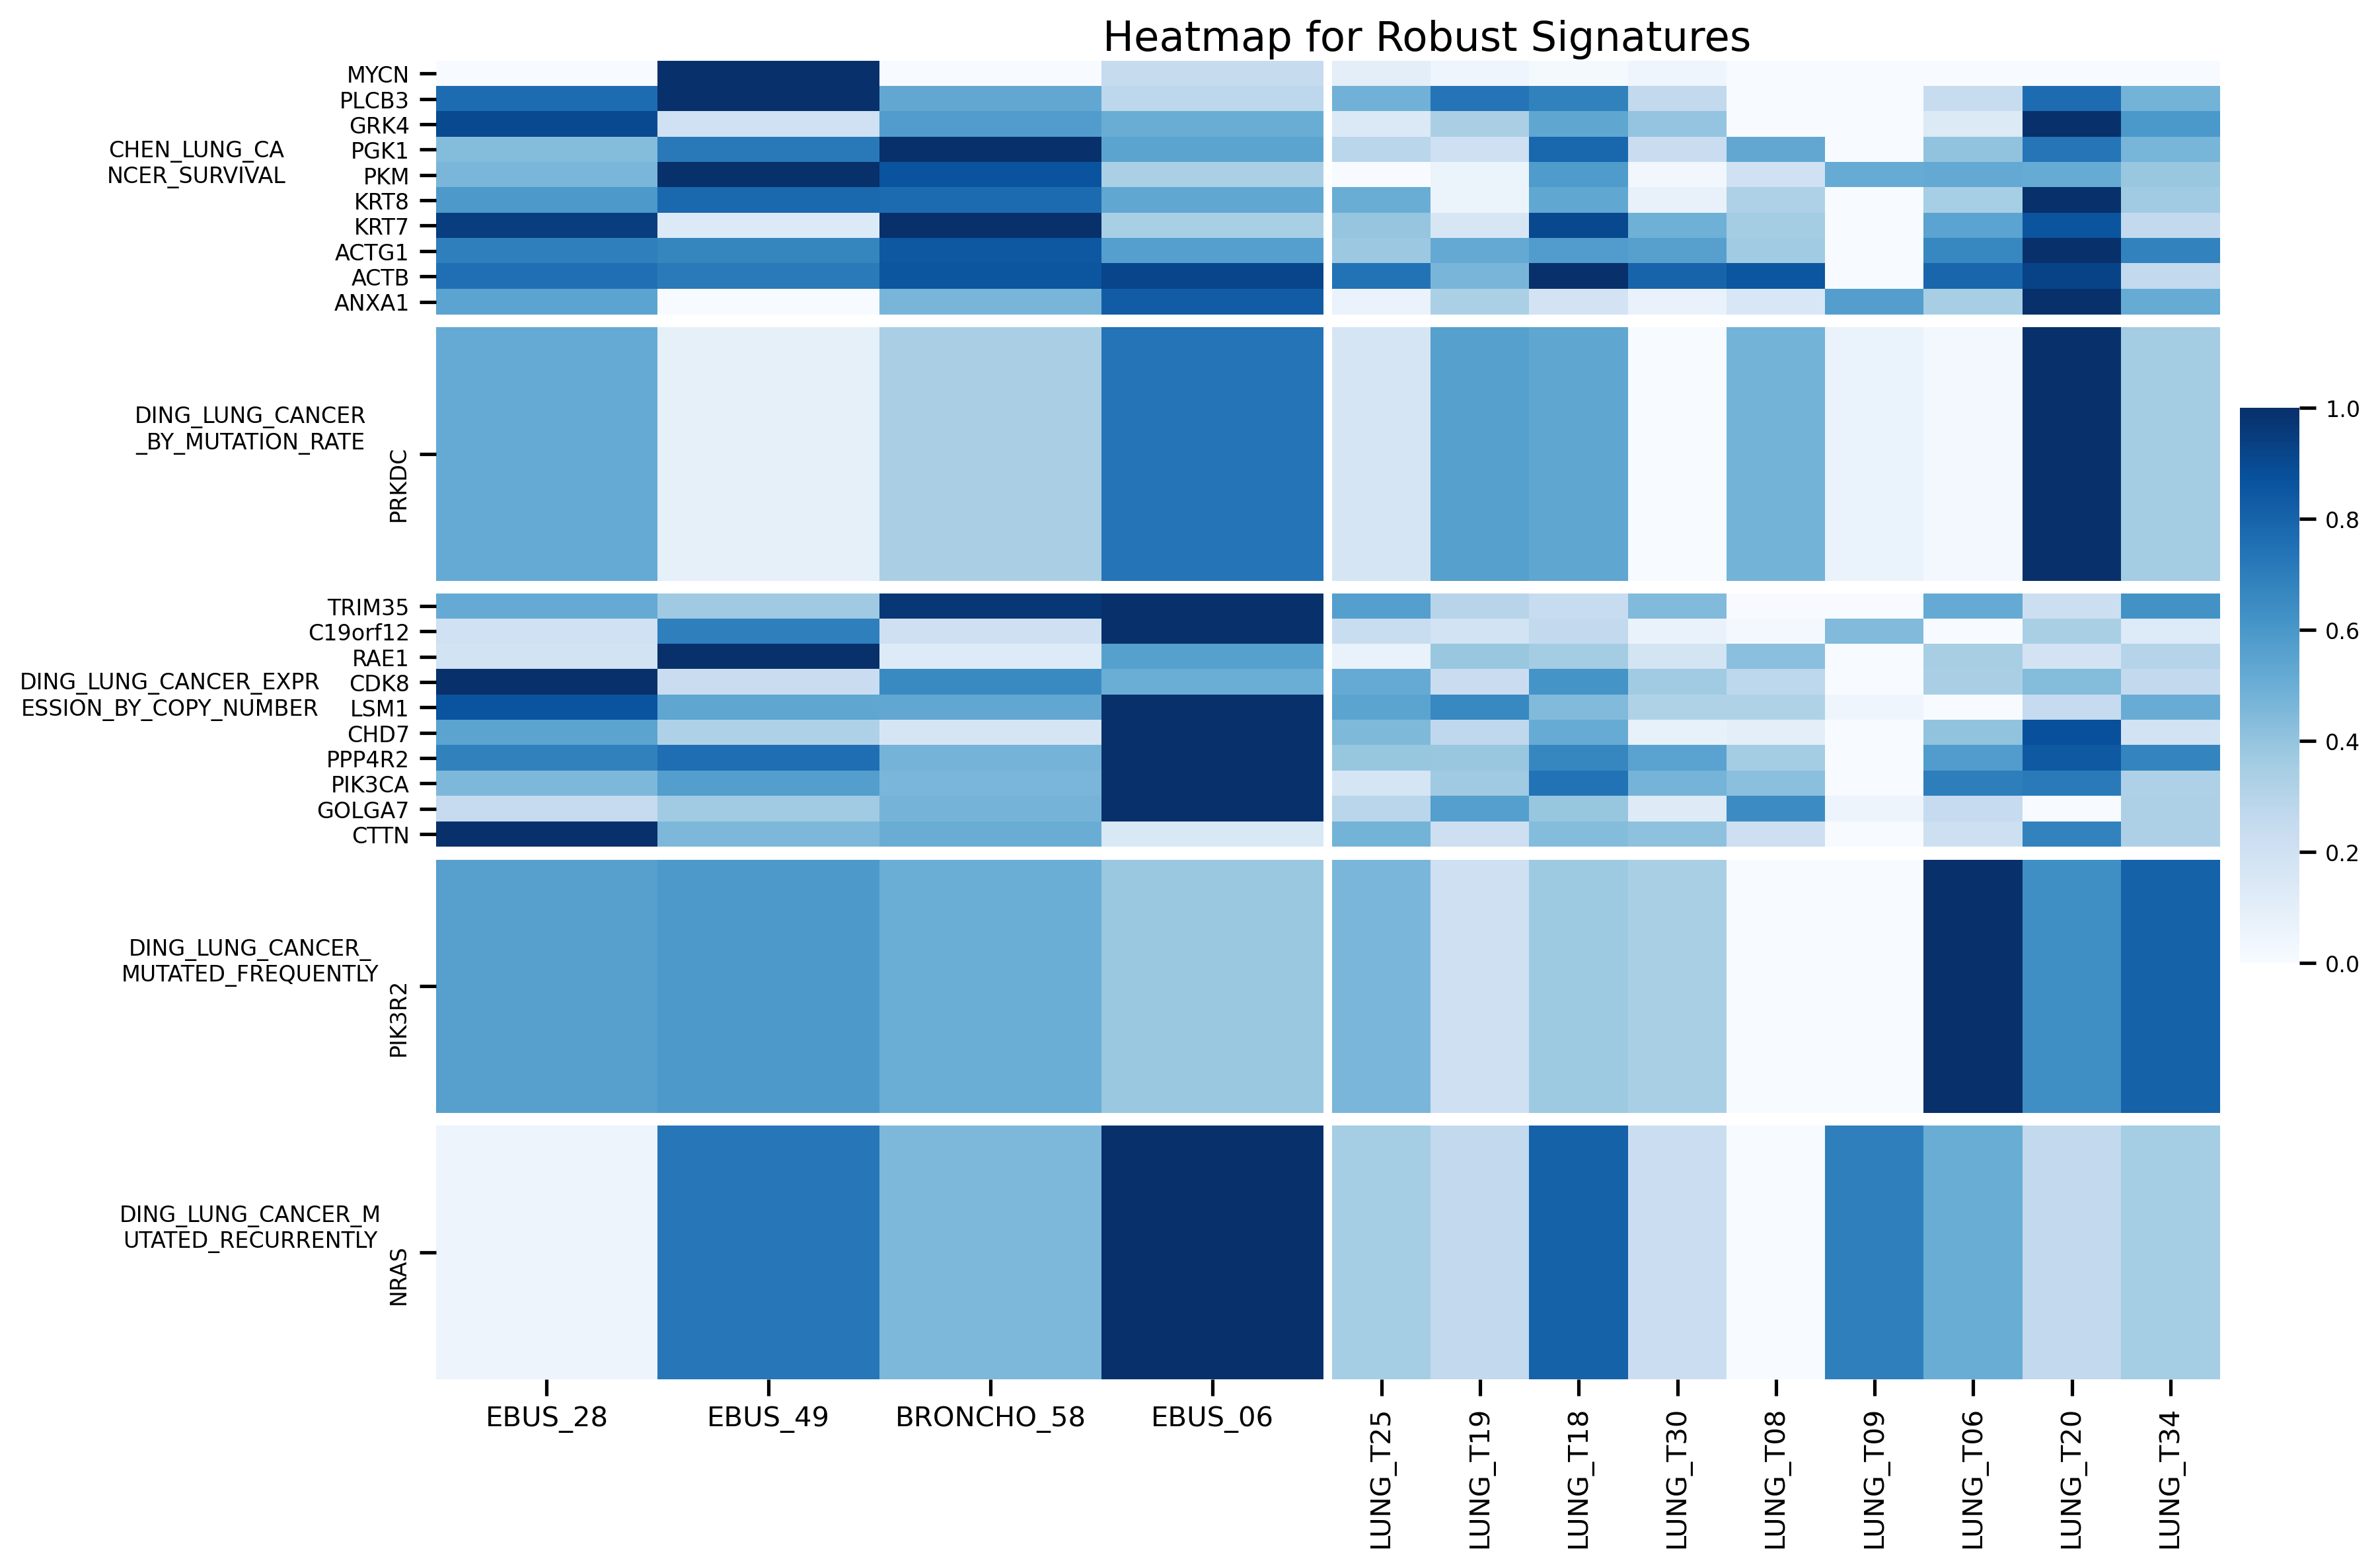

In [26]:
fig1 = GenerateHeatmap(counts_df.T, t1_ids, t2_ids, d1_all, d2_all, top_genes, signature_names_list[:5])

In [20]:
tfs_df = pd.read_csv("./beanie/data/TF.tsv", sep="\t")
tfs_df

,TF,Target,Mode of Regulation,References
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788
...,...,...,...,...
9391,ZNF76,CDKN1A,Repression,15280358
9392,ZNF76,PCYT1A,Activation,14702349
9393,ZNF76,TALDO1,Unknown,14702349
9394,ZNRD1,ABCB1,Activation,16373708


## Make UpsetPlot

In [ ]:
import upsetplot
from itertools import product

In [ ]:
upset_df_prep = pd.DataFrame(columns=top_genes.keys())
for x in top_genes.keys():
    upset_df_prep[x] = top_genes[x].index

In [ ]:
upset_df_prep

In [ ]:
top_features = upset_df_prep.columns[:6]

upset_df = pd.DataFrame(list(product([True,False],repeat = len(top_features))),columns=top_features)
intersection = list()
for i in range(upset_df.shape[0]):
    sig_names = upset_df.columns[upset_df.iloc[i,]]
    temp = upset_df_prep[sig_names]
    list_sigs = [set(temp.iloc[:,i].dropna()) for i in range(temp.shape[1])]
    if len(list_sigs)!=0:
        intersection.append(len(set.intersection(*list_sigs)))
    else:
        intersection.append(0)
upset_df["Intersection"] = intersection
upset_df = upset_df.groupby(by = top_features.to_list()).first()
upset_df

In [ ]:
upsetplot.plot(upset_df['Intersection'], sort_by='cardinality')